In [1091]:
import pandas as pd
df=pd.read_csv("Data Complete.csv")
df.sample(5)

,Unnamed: 0,Date,Open,Close,Adj Close,High,Low,Volume,MACD_Line,MACD_Signal,...,SMA_100,EMA_100,SMA_200,EMA_200,Close_LAG1,Close_LAG2,Close_LAG3,Close_LAG5,Close_LAG7,Close_LAG14
704,718,1998-10-01,8.515176,8.515176,6.003600,8.515176,8.515176,0,0.026892,0.014609,...,6.940665,6.790002,7.673561,7.348955,8.515176,8.622285,8.947183,8.975745,8.643707,8.400926
2246,2260,2004-09-01,33.964306,33.989300,28.562023,34.232079,33.853626,46091600,0.033664,0.083628,...,28.062438,28.317428,30.225094,28.178277,33.964306,33.360924,32.718269,32.703987,32.221996,33.935745
4966,4980,2015-09-01,195.187180,191.975586,181.981995,195.187180,190.889816,21645696,-7.896392,-6.317950,...,202.313211,202.486392,196.713843,200.533586,195.644348,199.415970,198.673065,193.872818,207.542099,215.531082
213,227,1996-11-13,6.497954,6.665758,4.378767,6.703246,6.497954,91577621,-0.085513,-0.044505,...,4.724061,4.734581,4.968420,4.804454,6.549723,6.549723,6.681824,6.531872,6.737164,7.522631
2720,2734,2006-07-24,109.948509,111.034279,96.694550,111.434296,107.605530,46571895,0.298379,1.713987,...,91.636920,90.824748,73.773402,78.237915,110.582825,113.765846,112.354347,117.880348,122.914886,122.829170


In [1092]:
df=df.drop(columns=['Unnamed: 0'])

# 5. Preparing Training & Testing Data for different cases

In [1093]:
train_size=int(len(df)*0.8)

### ARIMA

In [1094]:
train_arima=df['Adj Close'].iloc[:train_size]
test_arima=df['Adj Close'].iloc[train_size:]

print(type(train_arima),train_arima.shape)
print(type(test_arima),test_arima.shape)

<class 'pandas.core.series.Series'> (5964,)
<class 'pandas.core.series.Series'> (1492,)


### PROPHET

In [1095]:
prophet_df=df.reset_index()[['Date','Adj Close']]
prophet_df.columns=["ds","y"]

train_prophet=prophet_df.iloc[:train_size]
test_prophet=prophet_df.iloc[train_size:]

### LSTM/GRU for multi-step

In [1096]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))

In [1097]:
data_multi=scaler.fit_transform(df[['Adj Close']])

In [1098]:
import numpy as np
def create_multistep_sequences(data,n_steps,k):
    x=[]
    y=[]
    for i in range(n_steps,len(data)-k+1):
        x.append(data[i-n_steps:i])    # past n days
        y.append(data[i:i+k])          # next k days
    return np.array(x),np.array(y)

n_steps=100
k=1
x,y=create_multistep_sequences(data_multi,n_steps,k)

x=x.reshape((x.shape[0],x.shape[1],1))
x_train_multistep,x_test_multistep=x[:train_size],x[train_size:]
y_train_multistep,y_test_multistep=y[:train_size],y[train_size:]

### XGBOOST/RANDOMFOREST for next day close price and direction

In [1099]:
next_day_df=df.drop(columns=['Date'])
next_day_df['Target']=next_day_df['Close'].shift(-1)
x_next_day=next_day_df.drop(columns=['Target'])
y_next_day=next_day_df['Target']

In [1100]:
x_train_next_day,x_test_next_day=x_next_day[:train_size],x_next_day[train_size:]
y_train_next_day,y_test_next_day=y_next_day[:train_size],y_next_day[train_size:]





def prepare_xy(df, mode="regression", n_steps_in=60, n_steps_out=1):
    """
    mode: "regression", "classification", "arima", "prophet", "lstm"
    """
    if mode == "arima":
        return None, df["Close"]
    
    if mode == "prophet":
        prophet_df = df.reset_index()[["Date", "Close"]]
        prophet_df.columns = ["ds", "y"]
        return None, prophet_df
    
    if mode in ["regression", "classification"]:
        X = df[["Open", "High", "Low", "Close", "Volume", "MA_20", "MA_50", "Volatility"]]
        if mode == "regression":
            y = df["Close"].shift(-1)
        else:
            y = (df["Close"].shift(-1) > df["Close"]).astype(int)
        return X[:-1], y[:-1]
    
    if mode == "lstm":
        data = df["Close"].values
        X, y = [], []
        for i in range(len(data) - n_steps_in - n_steps_out):
            X.append(data[i:i+n_steps_in])
            y.append(data[i+n_steps_in:i+n_steps_in+n_steps_out])
        return np.array(X), np.array(y)


from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

def train_model(X, y, mode="regression", model_type="xgb", n_steps_in=60, n_steps_out=1):
    if model_type == "arima":
        model = ARIMA(y, order=(5,1,0)).fit()
        return model
    
    if model_type == "prophet":
        model = Prophet()
        model.fit(y)  # here y is prophet_df
        return model
    
    if model_type in ["xgb", "rf"]:
        if mode == "regression":
            model = XGBRegressor() if model_type=="xgb" else RandomForestRegressor()
        else:
            model = XGBClassifier() if model_type=="xgb" else RandomForestClassifier()
        model.fit(X, y)
        return model
    
    if model_type in ["lstm", "gru"]:
        model = Sequential()
        if model_type == "lstm":
            model.add(LSTM(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        else:
            model.add(GRU(50, return_sequences=False, input_shape=(n_steps_in, 1)))
        model.add(Dense(n_steps_out))
        model.compile(optimizer="adam", loss="mse")
        model.fit(X.reshape((X.shape[0], X.shape[1], 1)), y, epochs=10, batch_size=32, verbose=1)
        return model

# 6. Model Training

## (i) ARIMA

In [1101]:
import pmdarima as pm

train_arim=np.log(train_arima)
test_arim=np.log(test_arima)

model_arima=pm.auto_arima(train_arim,verbose=False)
forecast_arima=model_arima.predict(n_periods=len(test_arim))

forecast_arima=np.exp(forecast_arima)

root_mean_squared_error(test_arima,forecast_arima)

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finit

229.63668458060067

In [1102]:
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(test_arima,forecast_arima)*100

15.916584569412912

In [1103]:
a=df['Date'].iloc[train_size:]
a=pd.to_datetime(a)

In [1104]:
a.dtype

dtype('<M8[ns]')

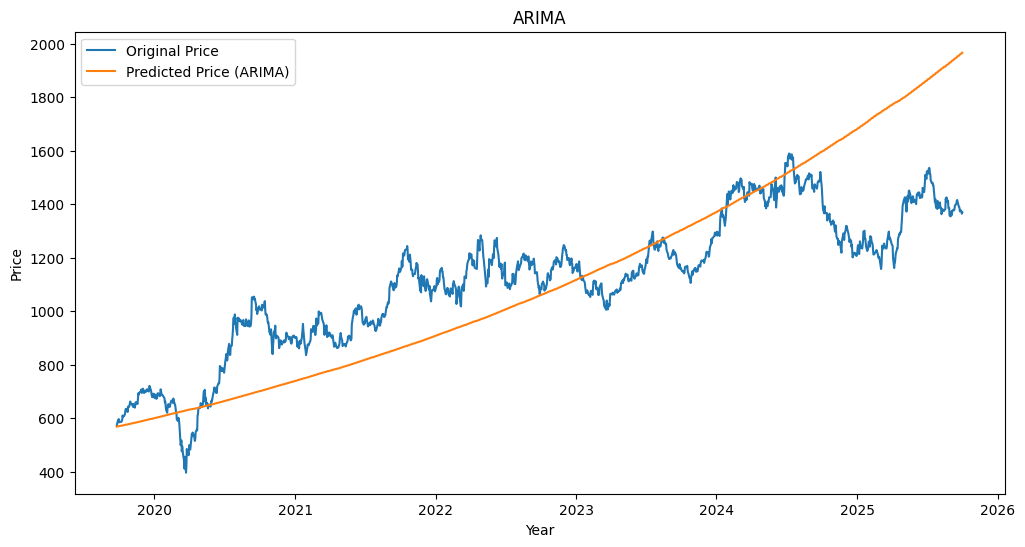

In [1105]:
plt.figure(figsize=(12,6))
plt.title("ARIMA")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_arima,label="Original Price")
plt.plot(a,forecast_arima,label='Predicted Price (ARIMA)')
plt.legend()

## (ii) PROPHET

In [1106]:
from prophet import Prophet

train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])

m=Prophet()
m.fit(train_prophet)

future_prophet=m.make_future_dataframe(periods=len(test_prophet))
forecast_prophet=m.predict(future_prophet)

/var/folders/nc/hvlqvddd2xj11jl0l69nx3580000gn/T/ipykernel_19660/2201988977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prophet['y'],test_prophet['y']=np.log(train_prophet['y']),np.log(test_prophet['y'])
22:28:49 - cmdstanpy - INFO - Chain [1] start processing
22:28:50 - cmdstanpy - INFO - Chain [1] done processing


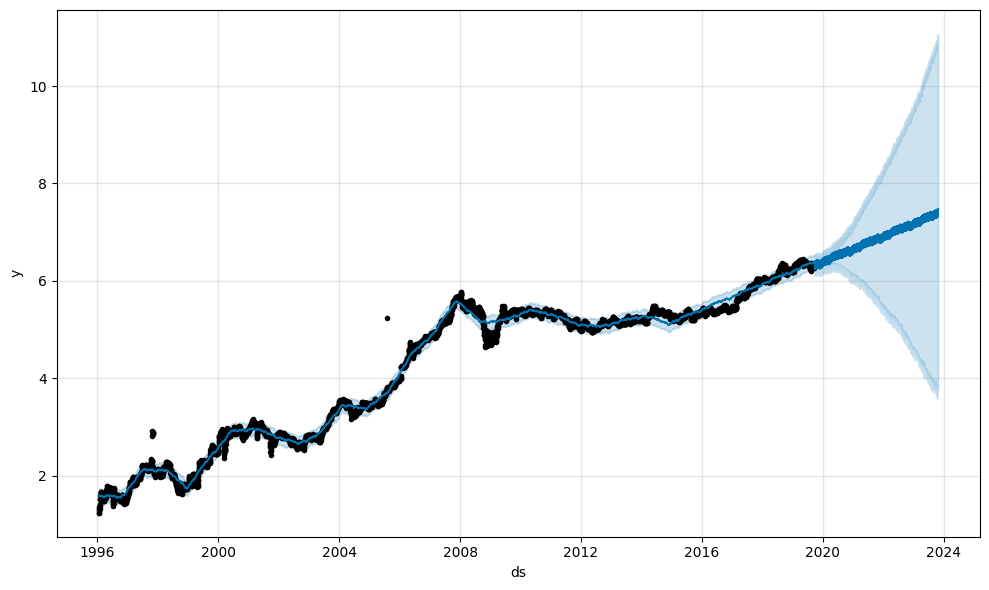

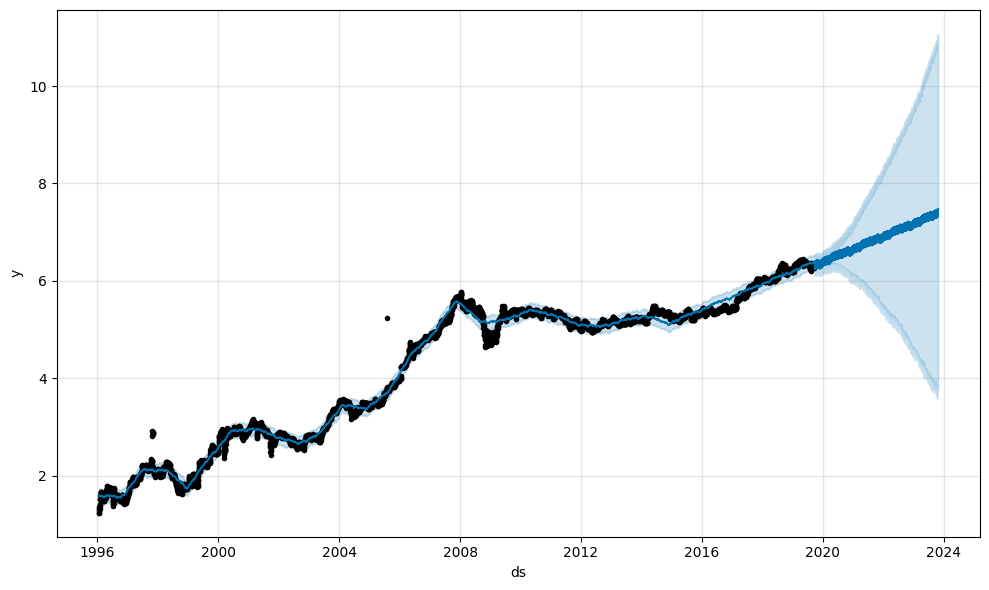

In [1107]:
m.plot(forecast_prophet)

In [1108]:
root_mean_squared_error(test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:])

0.19934426110627865

In [1109]:
test_prophet['y'],forecast_prophet['yhat'].iloc[train_size:]

(5964    6.349857
 5965    6.363248
 5966    6.372650
 5967    6.390217
 5968    6.369475
           ...   
 7451    7.224316
 7452    7.228098
 7453    7.224608
 7454    7.218177
 7455    7.221617
 Name: y, Length: 1492, dtype: float64,
 5964    6.394023
 5965    6.395340
 5966    6.392312
 5967    6.244698
 5968    6.244753
           ...   
 7451    7.319153
 7452    7.320591
 7453    7.469557
 7454    7.470714
 7455    7.473103
 Name: yhat, Length: 1492, dtype: float64)

In [1110]:
np.exp(test_prophet['y']),np.exp(forecast['yhat'].iloc[train_size:])

(5964     572.410706
 5965     580.127502
 5966     585.607544
 5967     595.986145
 5968     583.751038
            ...     
 7451    1372.400024
 7452    1377.599976
 7453    1372.800049
 7454    1364.000000
 7455    1368.699951
 Name: y, Length: 1492, dtype: float64,
 5964     586.781027
 5965     588.768331
 5966     588.166227
 5967     591.277324
 5968     593.944955
            ...     
 7462    1713.221498
 7463    1716.249839
 7464    1721.816444
 7465    1727.125336
 7466    1724.791387
 Name: yhat, Length: 1503, dtype: float64)

In [1111]:
test_proph=np.exp(test_prophet['y'])
predict_proph=np.exp(forecast_prophet['yhat'].iloc[train_size:])

In [1112]:
root_mean_squared_error(test_proph,predict_proph)

200.19630500704747

In [1113]:
mean_absolute_percentage_error(test_proph,predict_proph)*100

15.517845504399258

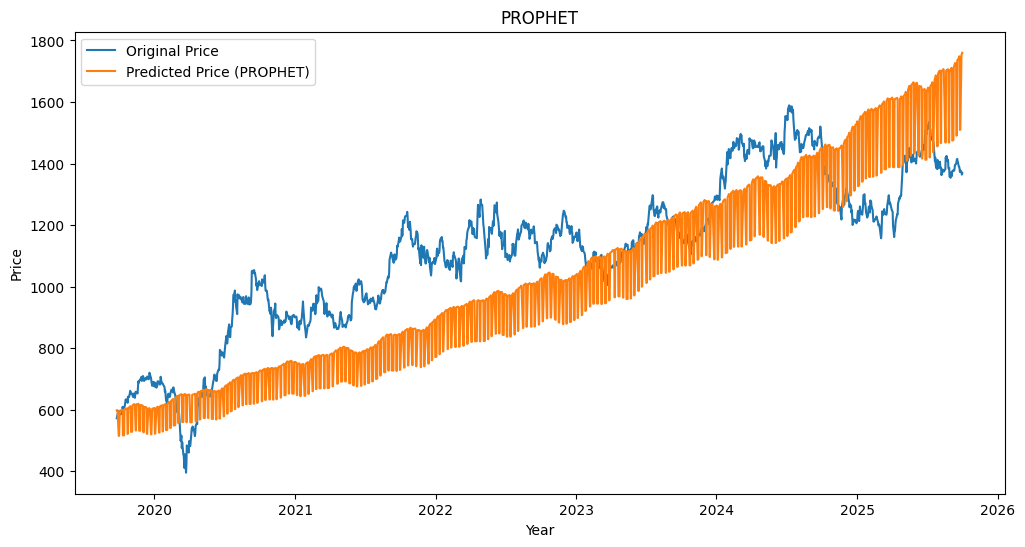

In [1114]:
plt.figure(figsize=(12,6))
plt.title("PROPHET")
plt.xlabel("Year")
plt.ylabel("Price")
plt.plot(a,test_proph,label='Original Price')
plt.plot(a,predict_proph,label='Predicted Price (PROPHET)')
plt.legend()

## (iii) LSTM

In [1115]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,LSTM,GRU

In [1142]:
lstm_model=Sequential([
    LSTM(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    #Dropout(0.2),
    LSTM(60),
    #Dropout(0.3),
    Dense(y_train_multistep.shape[1])
])

lstm_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                  │ (None, 100, 80)        │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 60)             │        33,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,141 (234.93 KB)

 Trainable params: 60,141 (234.93 KB)

 Non-trainable params: 0 (0.00 B)

In [1143]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
history_lstm=lstm_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 8.9061e-04 - val_loss: 1.2586e-04
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 2.2294e-05 - val_loss: 2.0167e-04
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.8322e-05 - val_loss: 2.4248e-04
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 2.1390e-05 - val_loss: 1.5388e-04
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 1.4252e-05 - val_loss: 3.0144e-04
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.8584e-05 - val_loss: 3.5133e-04
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.6673e-05 - val_loss: 1.1633e-04
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 1.3298e-05 - val_loss: 1.3606e-04
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 1.7276e-05 - val_loss: 1.1630e-04
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 1.6462e-05 - val_loss: 8.3466e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/

In [1144]:
y_pred_lstm=lstm_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [1145]:
y_pred_lstm.shape,y_test_multistep.shape

((1392, 1), (1392, 1, 1))

In [1146]:
y_pred_lstm,y_test_multistep

(array([[0.40756345],
        [0.41149274],
        [0.4116979 ],
        ...,
        [0.8196574 ],
        [0.818733  ],
        [0.81562185]], dtype=float32),
 array([[[0.42207548]],
 
        [[0.41703971]],
 
        [[0.40547278]],
 
        ...,
 
        [[0.86356838]],
 
        [[0.85801871]],
 
        [[0.86098269]]]))

In [1147]:
if y_test_multistep.shape[1]==1:
    y_test_lstm_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_lstm_squeezed=np.squeeze(y_test_multistep)

In [1148]:
y_test_lstm_squeezed.shape

(1392, 1)

In [1149]:
root_mean_squared_error(y_test_lstm_squeezed,y_pred_lstm)

0.03543775022021244

In [1150]:
real_lstm=scaler.inverse_transform(y_test_lstm_squeezed)
predicted_lstm=scaler.inverse_transform(y_pred_lstm)

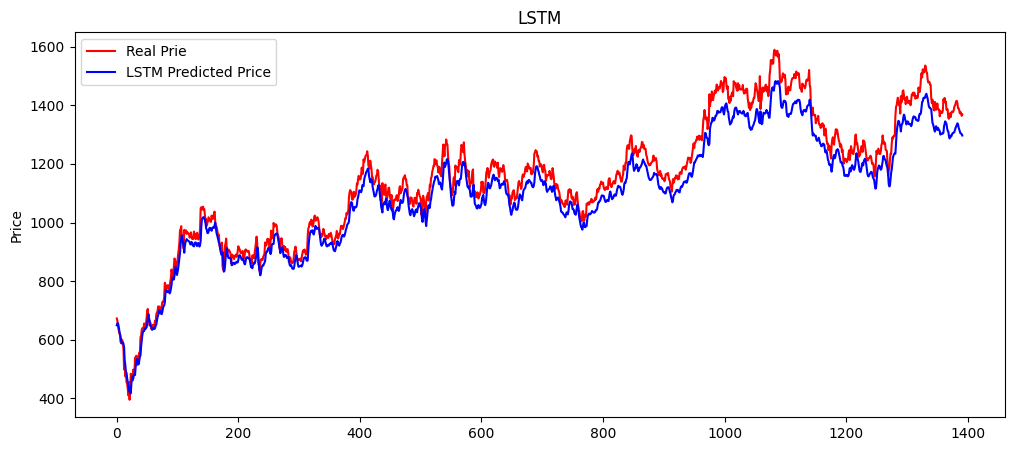

In [1151]:
plt.figure(figsize=(12,5))
plt.title("LSTM")
plt.ylabel("Price")
plt.plot(real_lstm,'r',label="Real Prie")
plt.plot(predicted_lstm,'b',label="LSTM Predicted Price")
plt.legend()

In [1152]:
root_mean_squared_error(real_lstm,predicted_lstm)

56.1932746755052

In [1153]:
mean_absolute_percentage_error(real_lstm,predicted_lstm)*100

4.173045793165183

## (iv) GRU

In [1154]:
gru_model=Sequential([
    GRU(80,input_shape=(x_train_multistep.shape[1],1),return_sequences=True),
    GRU(60),
    Dense(y_train_multistep.shape[1])
])
gru_model.summary()

/Users/akshatsinha/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_30 (GRU)                    │ (None, 100, 80)        │        19,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_31 (GRU)                    │ (None, 60)             │        25,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,541 (177.89 KB)

 Trainable params: 45,541 (177.89 KB)

 Non-trainable params: 0 (0.00 B)

In [1155]:
gru_model.compile(loss='mean_squared_error',optimizer='adam')
history_gru=gru_model.fit(x_train_multistep,y_train_multistep,epochs=30,batch_size=32,validation_split=0.2)

Epoch 1/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.8503e-04 - val_loss: 4.0294e-05
Epoch 2/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.1326e-05 - val_loss: 4.0742e-05
Epoch 3/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 8.7251e-06 - val_loss: 3.7881e-05
Epoch 4/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.9889e-06 - val_loss: 7.1945e-05
Epoch 5/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.0973e-05 - val_loss: 5.6978e-05
Epoch 6/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 8.3504e-06 - val_loss: 3.8360e-05
Epoch 7/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 7.8199e-06 - val_loss: 3.3253e-05
Epoch 8/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.9038e-06 - val_loss: 3.0669e-05
Epoch 9/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 1.0416e-05 - val_loss: 6.3701e-05
Epoch 10/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 9.3879e-06 - val_loss: 3.2460e-05
Epoch 11/30
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/

In [1156]:
y_pred_gru=gru_model.predict(x_test_multistep)

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step


In [1157]:
y_pred_gru.shape,y_test_multistep.shape

((1392, 1), (1392, 1, 1))

In [1158]:
y_pred_gru,y_test_multistep

(array([[0.42187497],
        [0.42963636],
        [0.42701736],
        ...,
        [0.86553955],
        [0.86311835],
        [0.8582639 ]], dtype=float32),
 array([[[0.42207548]],
 
        [[0.41703971]],
 
        [[0.40547278]],
 
        ...,
 
        [[0.86356838]],
 
        [[0.85801871]],
 
        [[0.86098269]]]))

In [1159]:
if y_test_multistep.shape[1]==1:
    y_test_gru_squeezed=y_test_multistep.reshape(-1,1)
else:
    y_test_gru_squeezed=np.squeeze(y_test_multistep)

In [1160]:
y_test_gru_squeezed.shape

(1392, 1)

In [1161]:
root_mean_squared_error(y_test_gru_squeezed,y_pred_gru)

0.012544883999896247

In [1162]:
y_test_gru_squeezed,y_pred_gru

(array([[0.42207548],
        [0.41703971],
        [0.40547278],
        ...,
        [0.86356838],
        [0.85801871],
        [0.86098269]]),
 array([[0.42187497],
        [0.42963636],
        [0.42701736],
        ...,
        [0.86553955],
        [0.86311835],
        [0.8582639 ]], dtype=float32))

In [1163]:
real_gru=scaler.inverse_transform(y_test_gru_squeezed)
predicted_gru=scaler.inverse_transform(y_pred_gru)

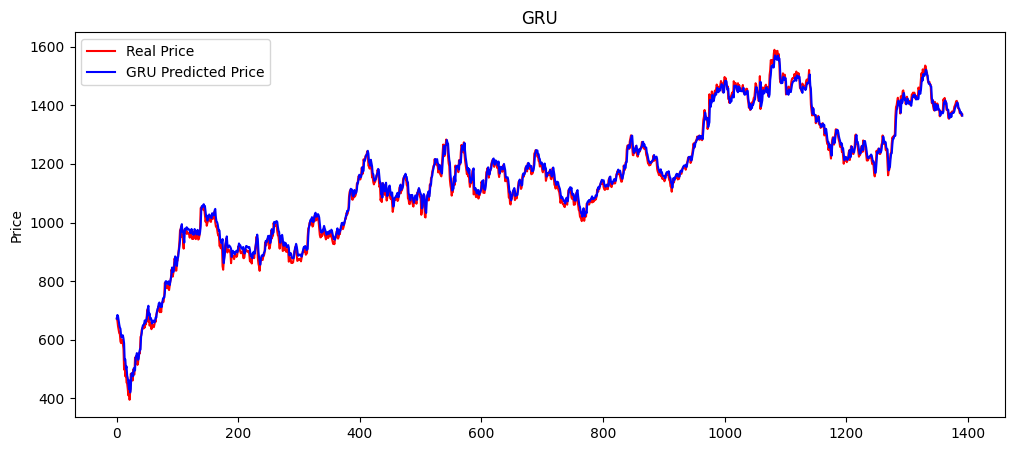

In [1164]:
plt.figure(figsize=(12,5))
plt.title("GRU")
plt.ylabel("Price")
plt.plot(real_gru,'r',label="Real Price")
plt.plot(predicted_gru,'b',label="GRU Predicted Price")
plt.legend()

In [1165]:
root_mean_squared_error(real_gru,predicted_gru)

19.892281566087473

In [1166]:
mean_absolute_percentage_error(real_gru,predicted_gru)*100

1.4372666213583918

In [1167]:
predicted_gru,real_gru

(array([[ 672.41156],
        [ 684.71875],
        [ 680.5658 ],
        ...,
        [1375.9257 ],
        [1372.0864 ],
        [1364.3888 ]], dtype=float32),
 array([[ 672.72955322],
        [ 664.74438477],
        [ 646.40283203],
        ...,
        [1372.80004883],
        [1364.        ],
        [1368.69995117]]))

## (v) XGBOOST for next day close price/direction

In [1168]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model_xgb=XGBRegressor()
model_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_next_day_xgb=model_xgb.predict(x_test_next_day)

In [1169]:
pred_xgb=y_pred_next_day_xgb[:-1]
test_xgb=y_test_next_day[:-1]

In [1170]:
root_mean_squared_error(test_xgb,pred_xgb)

558.4241931080292

In [1171]:
mean_absolute_percentage_error(test_xgb,pred_xgb)*100

41.73341222770163

In [986]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "n_estimators": [100, 200, 500],        # number of boosting rounds
    "max_depth": [3, 5, 7],                 # depth of trees
    "learning_rate": [0.01, 0.05, 0.1],     # step size shrinkage
    "subsample": [0.6, 0.8, 1.0],           # % of samples used per tree
    "colsample_bytree": [0.6, 0.8, 1.0],    # % of features used per tree
    "gamma": [0, 0.1, 0.3],                 # min loss reduction for split
    "reg_alpha": [0, 0.01, 0.1],            # L1 regularization
    "reg_lambda": [1, 1.5, 2]               # L2 regularization
}

grid_search=GridSearchCV(
    estimator=model_xgb,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1
)

In [987]:
grid_search.fit(x_train_next_day,y_train_next_day)

Fitting 3 folds for each of 6561 candidates, totalling 19683 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 0.1, 0.3],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 500],
                         'reg_alpha': [0, 0.01, 0.1], 'reg_lambda': [1, 1.5, 2],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [1172]:
grid_search.best_params_

{'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 1.0}

In [1173]:
grid_search.best_params_={'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 1.5,
 'subsample': 1.0}

In [1174]:
best_xgb=XGBRegressor(colsample_bytree=0.8,
 gamma=0,
 learning_rate=0.1,
 max_depth=3,
 n_estimators=100,
 reg_alpha=0,
 reg_lambda=1.5,
 subsample=1.0)

In [1175]:
best_xgb.fit(x_train_next_day,y_train_next_day)
y_pred_best_xgb=best_xgb.predict(x_test_next_day)

In [1176]:
y_pred_best_xgb=y_pred_best_xgb[:-1]

In [1177]:
root_mean_squared_error(test_xgb,y_pred_best_xgb)

557.2385239531952

In [1178]:
mean_absolute_percentage_error(test_xgb,y_pred_best_xgb)*100

41.64696315595236

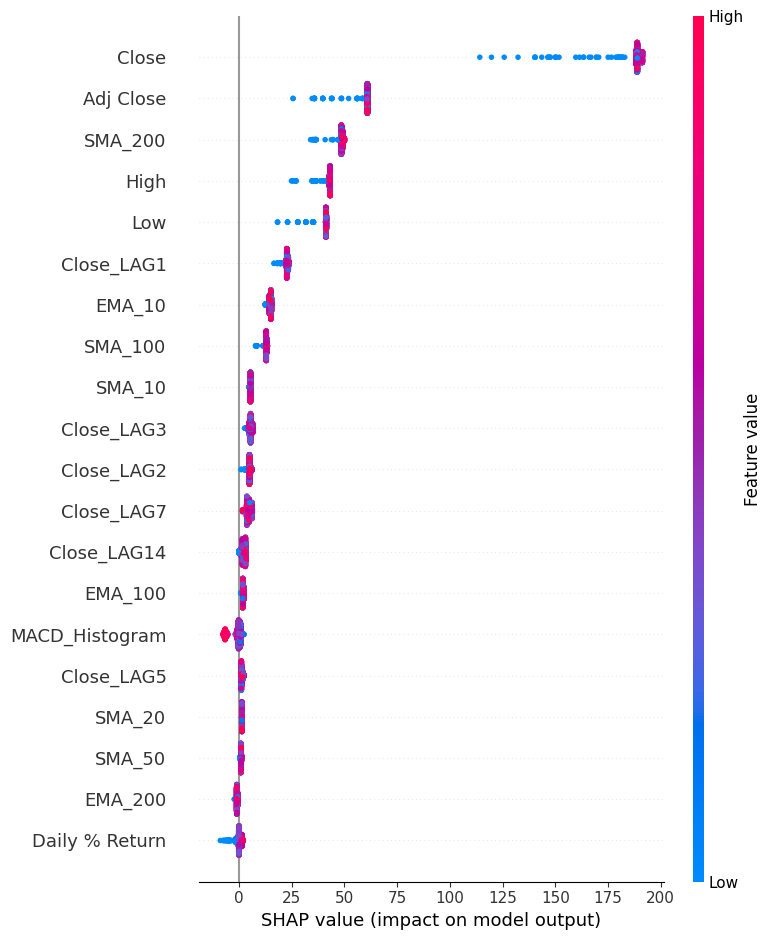

In [1179]:
# ---- SHAP Explainability ----
import shap
explainer=shap.Explainer(best_xgb,x_train_next_day)
shap_values=explainer(x_test_next_day)

# Global feature importance (summary plot)
shap.summary_plot(shap_values,x_test_next_day)

# Single prediction explanation (force plot)
shap.plots.force(shap_values[0])  # explains first prediction

## (vi) LightGBM

In [1180]:
lgb_reg=LGBMRegressor(
    boosting_type='gbdt',
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_reg.fit(
    x_train_next_day,y_train_next_day,
    eval_set=[(x_test_next_day,y_test_next_day)],
    eval_metric='rmse',
    #early_stopping_rounds=50,
    #verbose=-1
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 5964, number of used features: 27
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 153.637183


LGBMRegressor(learning_rate=0.05, n_estimators=1000, random_state=42)

In [1181]:
lgb_pred=lgb_reg.predict(x_test_next_day)

In [1182]:
root_mean_squared_error(test_xgb,lgb_pred[:-1])

558.5959367243921

In [1183]:
mean_absolute_percentage_error(test_xgb,lgb_pred[:-1])*100

41.79221760063446

 97%|=================== | 1448/1492 [00:33<00:01]       

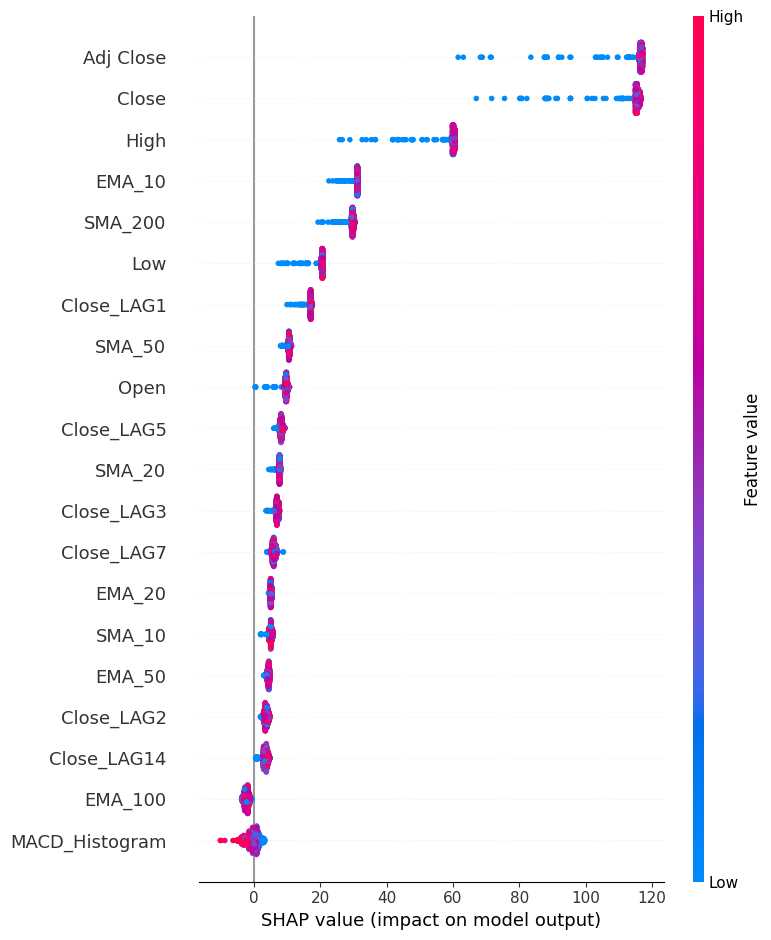

In [1184]:
explainer_lgbm=shap.Explainer(lgb_reg,x_train_next_day)
shap_values_lgbm=explainer_lgbm(x_test_next_day)

shap.summary_plot(shap_values_lgbm,x_test_next_day)

shap.plots.force(shap_values_lgbm[0])

### Comparing LSTM and GRU architectures. While LSTM achieved ~4.2% MAPE, GRU improved performance significantly to ~1.5%. This suggests that for highly volatile, short-memory data like stock prices, GRUs may be more efficient than LSTMs. This finding aligns with literature showing that GRUs can outperform LSTMs in scenarios with limited long-term dependencies